# Modeling

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import matplotlib.pyplot as plt

from src import Flag, AbstractTask, AbstractFlag, Pipeline, plotMatrix, plotReport
from src import plotFeatureImportance, plotTree, plotMatrix, plotReport

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataPath = r"..\data\csv" + "\\"
picklePath = r"..\pickle_objects\modeling_pipeline" + "\\"
plotPath = r"..\plots\modeling" + "\\"
tablePath = r"..\tables\modeling" + "\\"
modelPath = r"..\pickle_objects\models_and_scalers" + "\\"

In [3]:
import pickle
with open(picklePath + 'Modeling Pipeline.pickle', 'rb') as f:
    ModelingPipeline = pickle.load(f)

ModelingPipeline.print(priority = True, flags = True)

Modeling Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string
	20 Dummy Processing: Dummy Processing
		10 Dummies Channel
		20 Dummies AD Type
		30 Dummies Company
		40 Dummies UUID
		50 Dummies PDU Type
		60 Dummies Continuity Type
		70 Dummies SmartTag Type
	30 Labeling: Labeling
		10 Labeling auto: Labeling auto
			Label FindMy Tracker and iDevice: Label FindMy Tracker and iDevice
			Label Tile and

In [4]:
with open(picklePath + 'Pre Processing.pickle', 'rb') as f:
    flag_preProcessing = pickle.load(f)

with open(picklePath +  'Modeling.pickle', 'rb') as f:
    flag_modeling = pickle.load(f)

with open(picklePath + 'Dummy Processing.pickle', 'rb') as f:
    flag_dummy= pickle.load(f)

with open(picklePath + 'Drop Columns.pickle', 'rb') as f:
    flag_dropColumns= pickle.load(f)

with open(picklePath + 'Label FindMy Tracker and iDevice.pickle', 'rb') as f:
    flag_label_FindMy_Tracker_and_iDevice = pickle.load(f)

with open(picklePath + 'Label FindMy Tracker.pickle', 'rb') as f:
    flag_label_FindMy_Tracker = pickle.load(f)

with open(picklePath + 'Label Tile and iDevice.pickle', 'rb') as f:
    flag_label_Tile_and_iDevice = pickle.load(f)

with open(picklePath + 'Label Tile.pickle', 'rb') as f:
    flag_label_Tile = pickle.load(f)

with open(picklePath + 'Label SmartTag and Other.pickle', 'rb') as f:
    flag_label_SmartTag_and_Other = pickle.load(f)

with open(picklePath + 'Label SmartTag.pickle', 'rb') as f:
    flag_label_SmartTag = pickle.load(f)

with open(picklePath + 'Label iDevice.pickle', 'rb') as f:
    flag_label_iDevice= pickle.load(f)

with open(picklePath + 'State lost.pickle', 'rb') as f:
    flag_state_lost = pickle.load(f)

with open(picklePath + 'State unpaired.pickle', 'rb') as f:
    flag_state_unpaired = pickle.load(f)

with open(picklePath + 'State nearby.pickle', 'rb') as f:
    flag_state_nearby = pickle.load(f)

with open(picklePath + 'States iDevices.pickle', 'rb') as f:
    flag_states_iDevices = pickle.load(f)

with open(picklePath + 'Drop iDevice.pickle', 'rb') as f:
    flag_drop_label_iDevice = pickle.load(f)

with open(picklePath + 'Drop other Device.pickle', 'rb') as f:
    flag_drop_label_Other = pickle.load(f)

with open(picklePath + 'Rate Modeling.pickle', 'rb') as f:
    flag_Rate_Modeling = pickle.load(f)

with open(picklePath + 'Label other Device.pickle', 'rb') as f:
    flag_label_other_Device = pickle.load(f)

with open(picklePath + 'Drop iDevice FindMy.pickle', 'rb') as f:
    flag_drop_label_iDevice_FindMy = pickle.load(f)

with open(picklePath + 'Label Unknown.pickle', 'rb') as f:
    flag_label_Unknown = pickle.load(f)   


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def filesToDataFrame(filesDict: dict[str:AbstractFlag], filePath:str = dataPath, config:AbstractTask = ModelingPipeline, ) -> pd.DataFrame:
    dataset = pd.DataFrame()

    for f in filesDict.keys():
        new_dataset = Pipeline().setPath(filePath + f).setTask(config).loadData().run(flag=filesDict[f])
        dataset = pd.concat([dataset, new_dataset])

    dataset.reset_index(drop = True, inplace = True)

    return dataset

def prepareDataset(dataset:pd.DataFrame,  balance:bool = False, shuffle:bool = False, fraction:int = 1, labelColumn:str='Label') -> pd.DataFrame:
    if balance:
        min_count = dataset.groupby(labelColumn).size().min()
        dataset = dataset.groupby(labelColumn).sample(n = min_count*fraction, random_state=0).reset_index(drop = True)
        
    elif fraction < 1:
        dataset = dataset.sample(frac = fraction, random_state=0)

    if shuffle:
        dataset = dataset.sample(frac = 1, random_state=0)

    dataset.reset_index(drop = True, inplace = True)

    return dataset

def splitDataset(dataset:pd.DataFrame, dataset_unlabeled:pd.DataFrame = None, labelColumn:str ='Label'):
    Y = dataset[labelColumn]
    X = dataset.drop([labelColumn], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0, stratify = Y, shuffle = True)

    if not dataset_unlabeled is None:
        Y_unlabeled = unlabeledData[labelColumn]
        X_unlabeled = unlabeledData.drop(labelColumn, axis = 1)

        X_train = pd.concat([X_train, X_unlabeled])
        y_train = pd.concat([y_train, Y_unlabeled])
        
    X_train.reset_index(drop = True, inplace = True)
    X_test.reset_index(drop = True, inplace = True)

    return X_train, X_test, y_train, y_test

def scaleDataset(X_train: pd.DataFrame, X_test: pd.DataFrame, saveName:str = None):
    scaler = MinMaxScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    saveScaler(scaler, saveName)
    
    return X_train, X_test, scaler


def saveModel(model, name: str, savePath:str = modelPath):
    if savePath is not None and name is not None:
        with open(savePath + name + ' model.pickle', 'wb') as f:
            pickle.dump(model, f)

def saveScaler(scaler, name:str, savePath:str = modelPath):
    if savePath is not None and name is not None:
        with open(savePath + name + ' scaler.pickle', 'wb') as f:
            pickle.dump(scaler, f)

def trainModel(X_train: pd.DataFrame,
                  X_test: pd.DataFrame, 
                  y_train: pd.DataFrame, 
                  y_test: pd.DataFrame,
                  model,
                  report:bool = True,
                  matrix:bool = True,
                  saveName:str = None):
    
    model = model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
        
    if report or matrix:
        print("\n")

    if report:
        plotReport(y_test, y_test_pred, model.classes_, savePath=tablePath, name=saveName)

    if matrix:
        plotMatrix(y_test, y_test_pred, model.classes_, savePath = plotPath, name = saveName, dpi=100, digits=1)

    saveModel(model, saveName)

    return model, accuracy_score(y_test, y_test_pred)

def evaluateModel(dataset: pd.DataFrame, 
                  model = MLPClassifier(max_iter = 200, verbose = True, random_state = 0, tol = 0.0001, early_stopping = True, validation_fraction = 0.25), 
                  saveName:str = None,
                  report:bool = True,
                  matrix:bool = True,
                  dataset_unlabeled = None):
    
    X_train, X_test, y_train, y_test = splitDataset(dataset, dataset_unlabeled = dataset_unlabeled)
    X_train, X_test, scaler = scaleDataset(X_train, X_test, saveName=saveName)

    model, score = trainModel(X_train, X_test, y_train, y_test, model=model, saveName = saveName, report = report, matrix = matrix)
    return model, scaler, score


In [6]:
def FilesDictFactory(BaseModelingFlag: AbstractFlag):
    iDevice_Flag = Flag("iDevice", parents = [BaseModelingFlag, flag_label_iDevice, flag_states_iDevices])

    FindMyTrackerNearby_Flag = Flag("FindMy Tracker nearby", parents = [BaseModelingFlag, flag_label_FindMy_Tracker_and_iDevice, flag_state_nearby, 
                                                                        flag_drop_label_iDevice])
    FindMyTrackerLost_Flag = Flag("FindMy Tracker lost", parents = [BaseModelingFlag, flag_label_FindMy_Tracker, flag_state_lost])
    FindMyTrackerUnpaired_Flag = Flag("FindMy Tracker unpaired", parents = [BaseModelingFlag, flag_label_FindMy_Tracker, flag_state_unpaired])
    
    files = {r"AirTag\AirTag_(nearby).csv": FindMyTrackerNearby_Flag,
             r"AirTag\AirTag_(lost).csv": FindMyTrackerLost_Flag,
             r"AirTag\AirTag_(unpaired).csv": FindMyTrackerUnpaired_Flag,
    
             r"AirPod\AirPod_(lost).csv": Flag("lost", parents = [BaseModelingFlag, flag_label_iDevice, flag_states_iDevices, flag_drop_label_iDevice_FindMy]),
    
             r"Chipolo\Chipolo_(nearby).csv": FindMyTrackerNearby_Flag,
             r"Chipolo\Chipolo_(lost).csv": FindMyTrackerLost_Flag,
    
             r"SkyTag\SkyTag_(nearby).csv": FindMyTrackerNearby_Flag,
             r"SkyTag\SkyTag_(lost).csv": FindMyTrackerLost_Flag,
    
             r"Tile\Tile_(nearby).csv": Flag("lost nearby", parents = [BaseModelingFlag, flag_label_Tile_and_iDevice, flag_state_lost, flag_drop_label_iDevice]),
             r"Tile\Tile_(lost).csv": Flag("lost", parents = [BaseModelingFlag, flag_label_Tile, flag_state_lost]),
    
             r"SmartTag\SmartTag_(nearby).csv": Flag("nearby", parents = [BaseModelingFlag, flag_label_SmartTag_and_Other, flag_state_nearby, 
                                                                          flag_drop_label_Other]),
             r"SmartTag\SmartTag_(lost).csv": Flag("lost", parents = [BaseModelingFlag, flag_label_SmartTag, flag_state_lost]),
    
             r"iPhone\iPhone_(online).csv":iDevice_Flag,
             r"iPhone\iPhone_(offline).csv": iDevice_Flag,
    
             r"iPad\iPad_(online).csv": iDevice_Flag,
             r"iPad\iPad_(offline).csv": iDevice_Flag,
    
             r"MacBook\MacBook_(online).csv": iDevice_Flag,
             r"MacBook\MacBook_(offline).csv": iDevice_Flag,
    
             r"other Device\other Device.csv": Flag("other Device", parents = [BaseModelingFlag, flag_label_other_Device])
             }
    
    return files

In [7]:
flag = Flag("Base Modeling", parents = [flag_preProcessing, flag_dummy, flag_modeling, flag_dropColumns])
files = FilesDictFactory(flag)

rawData = filesToDataFrame(files)

data = prepareDataset(rawData, shuffle=True, balance=True)

Iteration 1, loss = 0.30063687
Validation score: 0.997426
Iteration 2, loss = 0.01345359
Validation score: 0.997426
Iteration 3, loss = 0.01126763
Validation score: 0.997426
Iteration 4, loss = 0.01070175
Validation score: 0.997426
Iteration 5, loss = 0.01037612
Validation score: 0.997426
Iteration 6, loss = 0.01024556
Validation score: 0.997404
Iteration 7, loss = 0.01012507
Validation score: 0.997426
Iteration 8, loss = 0.01001657
Validation score: 0.997426
Iteration 9, loss = 0.01001480
Validation score: 0.997449
Iteration 10, loss = 0.00993497
Validation score: 0.997426
Iteration 11, loss = 0.00986415
Validation score: 0.997449
Iteration 12, loss = 0.00994637
Validation score: 0.997449
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Classification Report - Neural Network
                           precision    recall  f1-score   support

    FindMy Tracker (lost)     0.9830    0.9998    0.9913      6010
  FindMy Tracker (nearby)     0.9

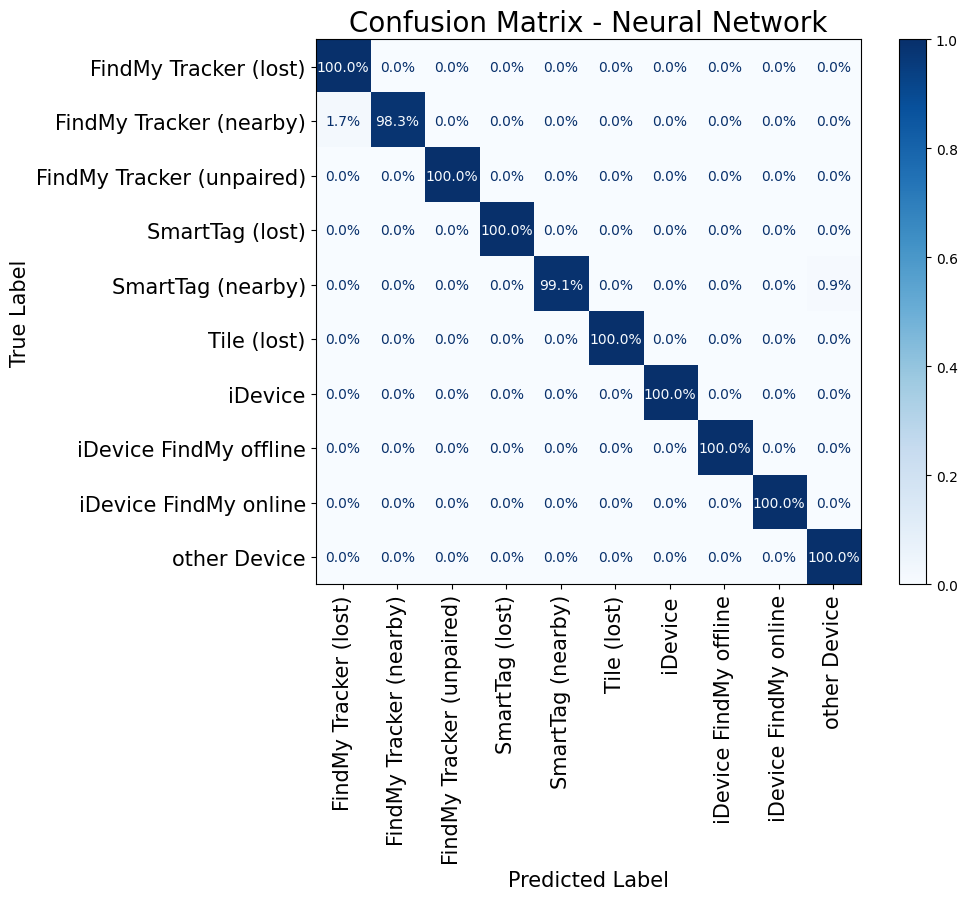

(MLPClassifier(early_stopping=True, random_state=0, validation_fraction=0.25,
               verbose=True),
 MinMaxScaler(),
 0.9972543472834678)

In [8]:
evaluateModel(data.copy(deep = True), saveName='Neural Network')

In [9]:
flag = Flag("Label Unknown", parents = [flag_preProcessing, flag_dummy, flag_modeling, flag_dropColumns, flag_label_Unknown])
files_unlabeled = {r"Inference\Bahnhof_V1.csv": flag}
unlabeledData = filesToDataFrame(files_unlabeled)

End of iteration 1, added 68528 new labels.
End of iteration 2, added 2775 new labels.
End of iteration 3, added 1281 new labels.
End of iteration 4, added 11101 new labels.
End of iteration 5, added 295 new labels.

Classification Report - SelfTrainer
                           precision    recall  f1-score   support

    FindMy Tracker (lost)     0.9830    0.9998    0.9913      6010
  FindMy Tracker (nearby)     1.0000    0.9824    0.9911      6009
FindMy Tracker (unpaired)     1.0000    1.0000    1.0000      6009
          SmartTag (lost)     1.0000    1.0000    1.0000      6010
        SmartTag (nearby)     1.0000    0.9950    0.9975      6009
              Tile (lost)     1.0000    1.0000    1.0000      6010
                  iDevice     0.9998    1.0000    0.9999      6010
   iDevice FindMy offline     1.0000    1.0000    1.0000      6010
    iDevice FindMy online     1.0000    1.0000    1.0000      6009
             other Device     0.9945    0.9998    0.9972      6009

        

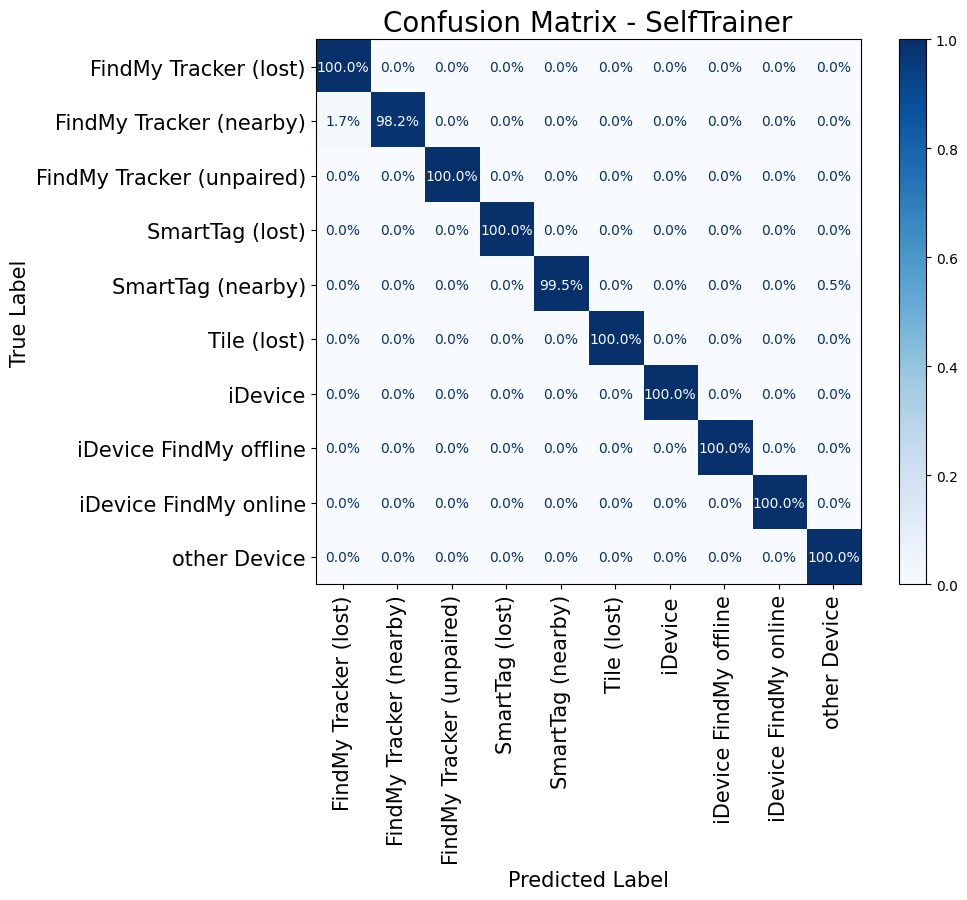

In [10]:
from sklearn.semi_supervised import SelfTrainingClassifier

model = MLPClassifier(max_iter = 200, verbose = False, random_state = 0, tol = 0.0001, early_stopping = True, validation_fraction = 0.25)
selfTrainer = SelfTrainingClassifier(model, threshold=0.99, max_iter=5, verbose=True)
modelName = 'SelfTrainer'

model, scaler, score = evaluateModel(data.copy(deep = True), dataset_unlabeled=unlabeledData, model = selfTrainer, 
                                     saveName=modelName)


Classification Report - Decision Tree
                           precision    recall  f1-score   support

    FindMy Tracker (lost)     0.9830    0.9998    0.9913      6010
  FindMy Tracker (nearby)     1.0000    0.9827    0.9913      6009
FindMy Tracker (unpaired)     1.0000    1.0000    1.0000      6009
          SmartTag (lost)     1.0000    1.0000    1.0000      6010
        SmartTag (nearby)     1.0000    0.9952    0.9976      6009
              Tile (lost)     1.0000    1.0000    1.0000      6010
                  iDevice     0.9998    1.0000    0.9999      6010
   iDevice FindMy offline     1.0000    1.0000    1.0000      6010
    iDevice FindMy online     1.0000    1.0000    1.0000      6009
             other Device     0.9950    0.9998    0.9974      6009

                 accuracy                         0.9978     60095
                macro avg     0.9978    0.9978    0.9978     60095
             weighted avg     0.9978    0.9978    0.9978     60095


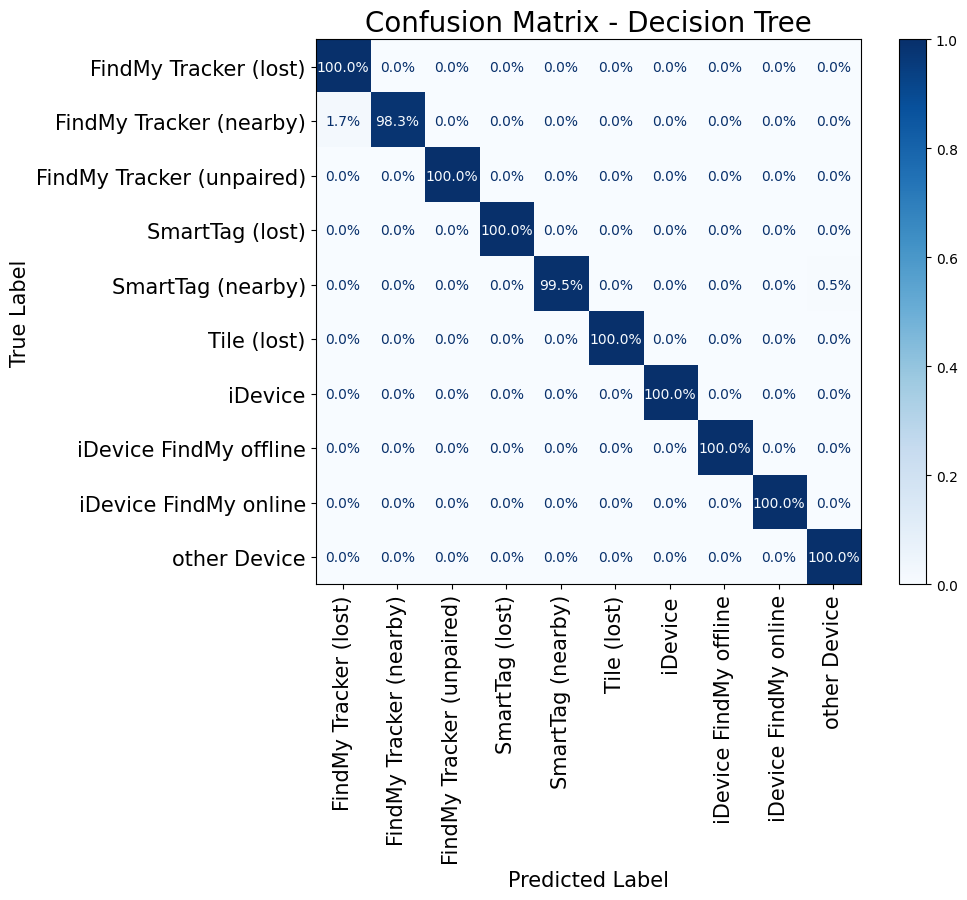

In [11]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(random_state = 0)
modelName = 'Decision Tree'

model, scaler, score = evaluateModel(data.copy(deep = True), model = DT, saveName=modelName) 

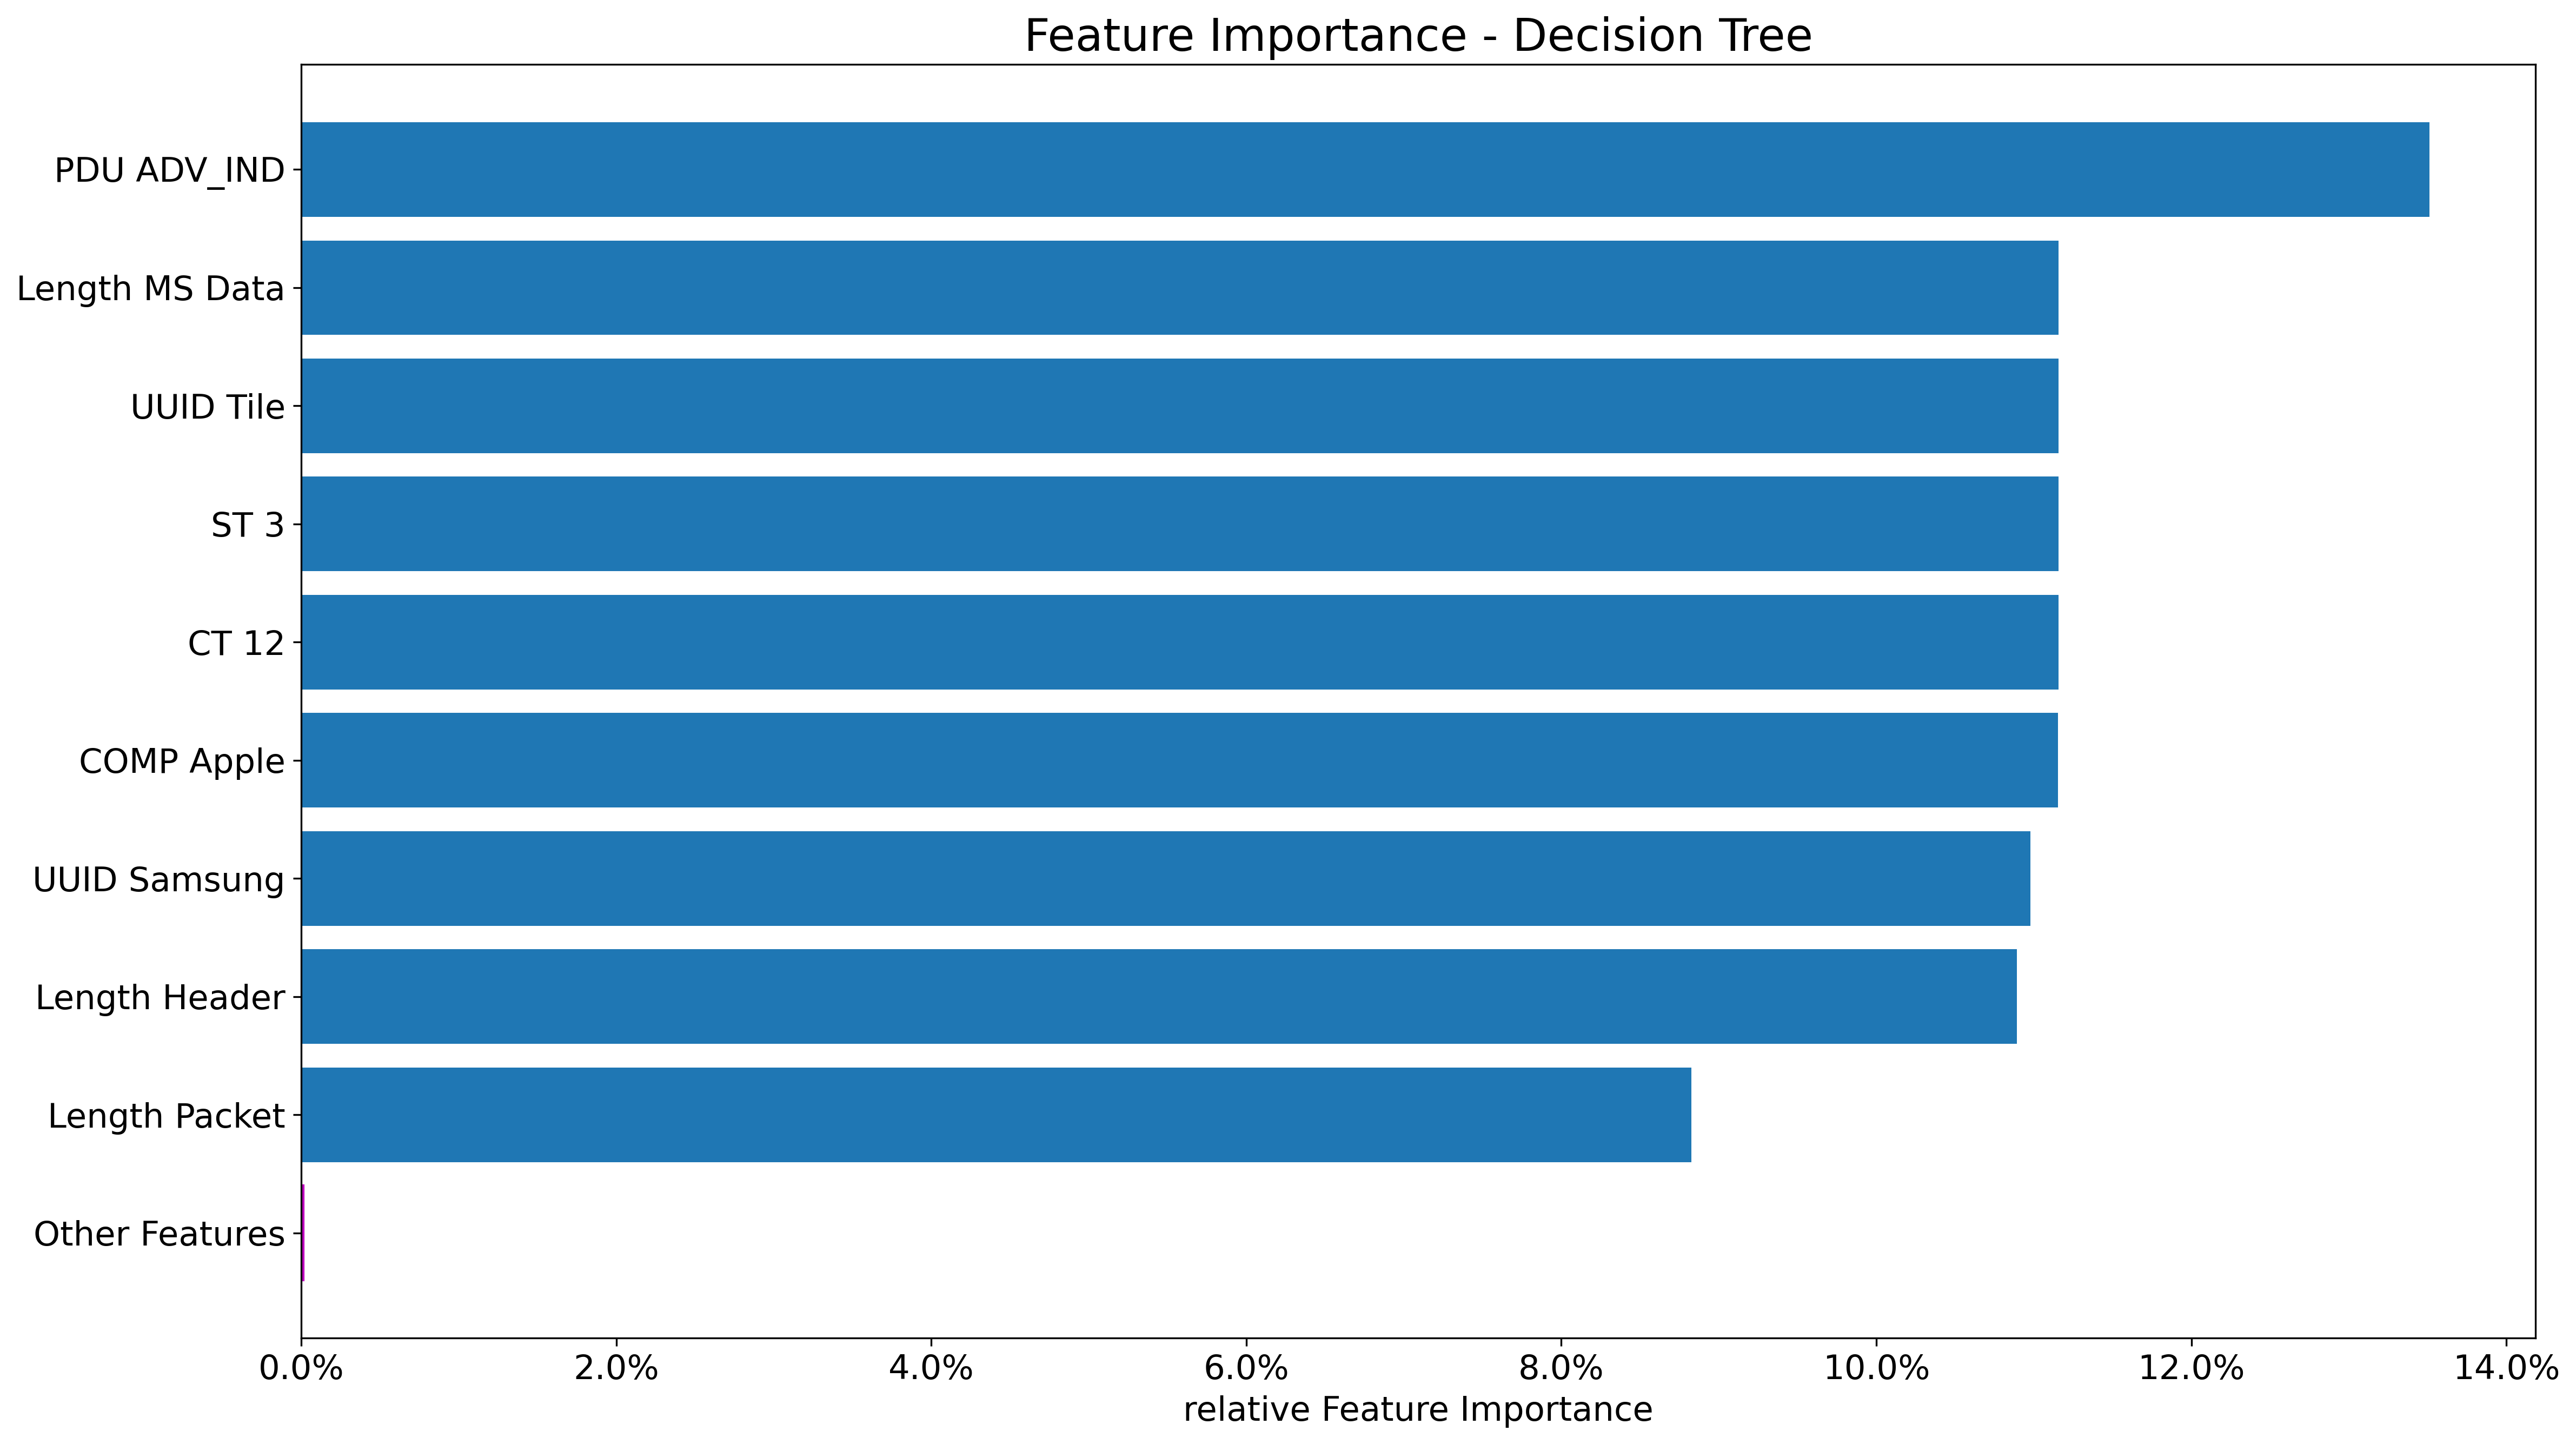

In [12]:
plotFeatureImportance(data.columns[:-1], model.feature_importances_, savePath=plotPath, name=modelName)

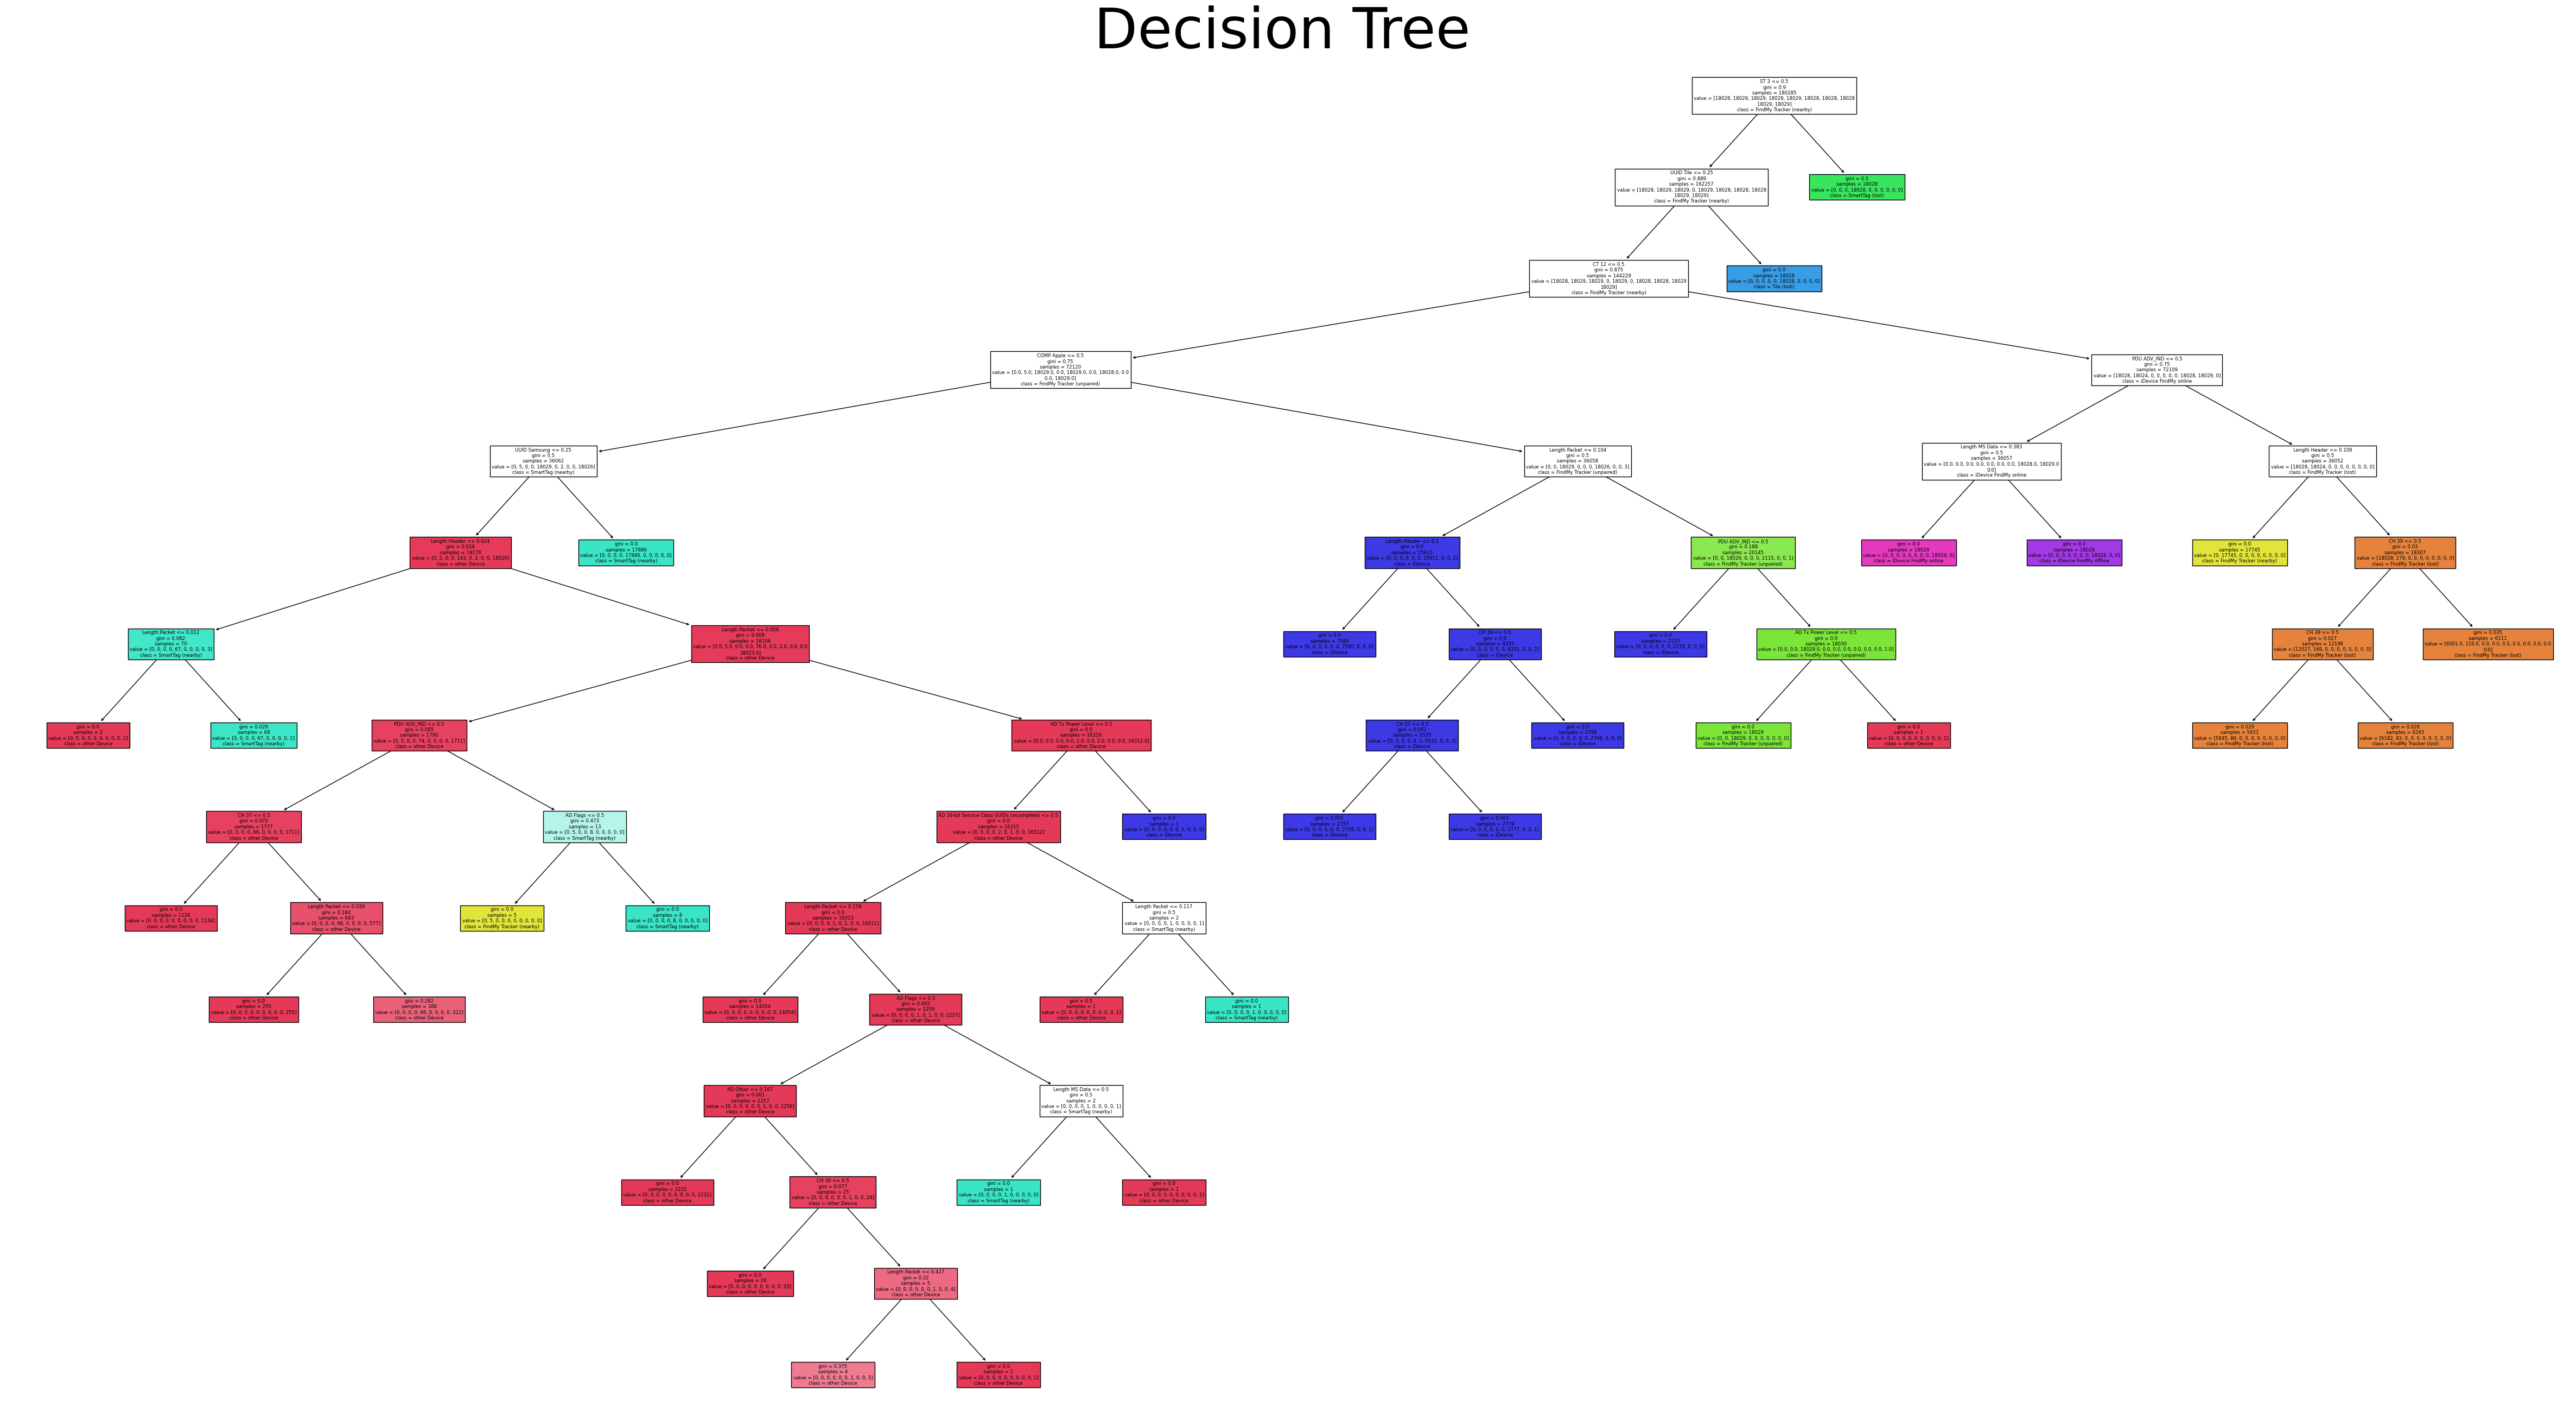

In [13]:
plotTree(model, savePath=plotPath, features_names= data.columns[:-1], name=modelName, sizeFactor=3)

In [14]:
import numpy as np
np.random.seed(0)

fractions = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1]
scores = []


for frac in fractions:
    print("Current Training Fraction: ", frac)
    
    X_train, X_test, y_train, y_test = splitDataset(data.copy())
    X_train, X_test, scaler = scaleDataset(X_train, X_test)
    
    cutOff = int(frac*len(X_train))
    index = np.random.randint(0, len(X_train)-1, size = cutOff)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_train = X_train[index]
    y_train = y_train[index]
    
    model , score = trainModel( X_train, X_test, y_train, y_test, model = DecisionTreeClassifier(random_state = 0), 
                                report=False, matrix=False)
    
    scores.append(score)

Current Training Fraction:  0.015625
Current Training Fraction:  0.03125
Current Training Fraction:  0.0625
Current Training Fraction:  0.125
Current Training Fraction:  0.25
Current Training Fraction:  0.5
Current Training Fraction:  1


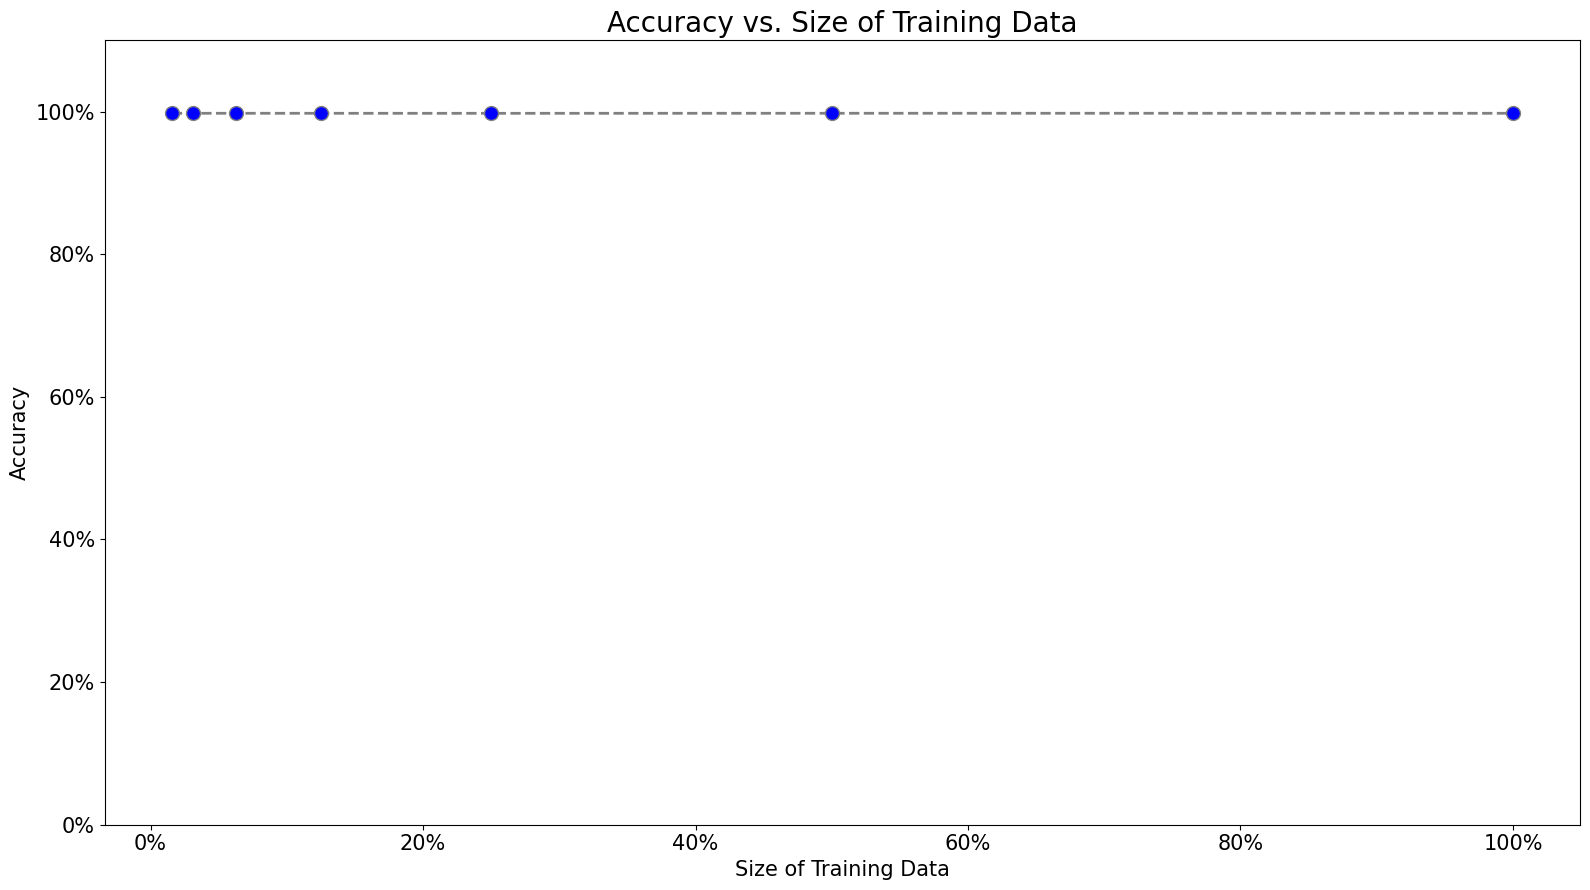

In [15]:
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(16, 9), dpi=100)
plt.plot(fractions, scores, ls="--", marker="o", color='grey', markerfacecolor="blue", markersize=10, lw=2)
title = "Accuracy vs. Size of Training Data"
plt.title(title, fontsize=20)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Size of Training Data", fontsize=15)
plt.ylim(bottom = 0, top = 1.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig(plotPath + title + ".png", dpi = 300)
plt.show()

In [16]:
flag = Flag("Rate Modeling", parents = [flag_preProcessing, flag_dummy, flag_modeling, flag_Rate_Modeling, flag_dropColumns])
files = FilesDictFactory(flag)

rawData = filesToDataFrame(files)

data = prepareDataset(rawData, shuffle=True, balance=True)



Classification Report - Rate Model
                           precision    recall  f1-score   support

    FindMy Tracker (lost)     0.9827    0.9991    0.9908      1080
  FindMy Tracker (nearby)     0.9990    0.9426    0.9700      1080
FindMy Tracker (unpaired)     1.0000    0.9991    0.9995      1080
          SmartTag (lost)     1.0000    1.0000    1.0000      1080
        SmartTag (nearby)     0.9960    0.9157    0.9542      1080
              Tile (lost)     1.0000    1.0000    1.0000      1080
                  iDevice     0.9989    0.8454    0.9157      1080
   iDevice FindMy offline     1.0000    0.9880    0.9939      1080
    iDevice FindMy online     1.0000    1.0000    1.0000      1080
             other Device     0.7741    0.9963    0.8713      1080

                 accuracy                         0.9686     10800
                macro avg     0.9751    0.9686    0.9695     10800
             weighted avg     0.9751    0.9686    0.9695     10800


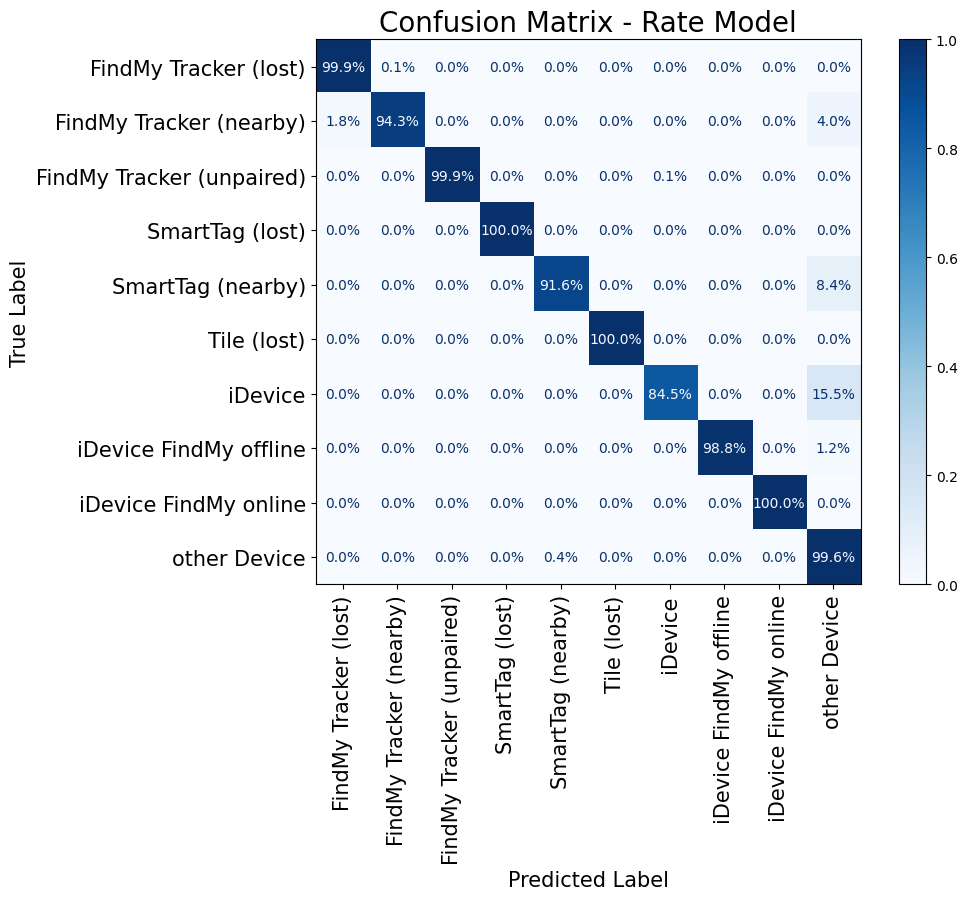

In [17]:
model, scaler, score = evaluateModel(data.copy(deep = True), saveName="Rate Model", model =  DecisionTreeClassifier(random_state = 0))

In [18]:
epsilon = 1e-10
data_filtered = rawData[rawData.iloc[:,:-1].max(axis = 1) > epsilon]



Classification Report - Rate Model (filtered)
                           precision    recall  f1-score   support

    FindMy Tracker (lost)     0.9872    1.0000    0.9936      1080
  FindMy Tracker (nearby)     0.9972    0.9861    0.9916      1080
FindMy Tracker (unpaired)     1.0000    1.0000    1.0000      1080
          SmartTag (lost)     1.0000    1.0000    1.0000      1080
        SmartTag (nearby)     0.9908    1.0000    0.9954      1080
              Tile (lost)     1.0000    1.0000    1.0000      1080
                  iDevice     0.9954    0.9954    0.9954      1080
   iDevice FindMy offline     1.0000    0.9991    0.9995      1080
    iDevice FindMy online     0.9991    1.0000    0.9995      1080
             other Device     0.9944    0.9833    0.9888      1080

                 accuracy                         0.9964     10800
                macro avg     0.9964    0.9964    0.9964     10800
             weighted avg     0.9964    0.9964    0.9964     10800


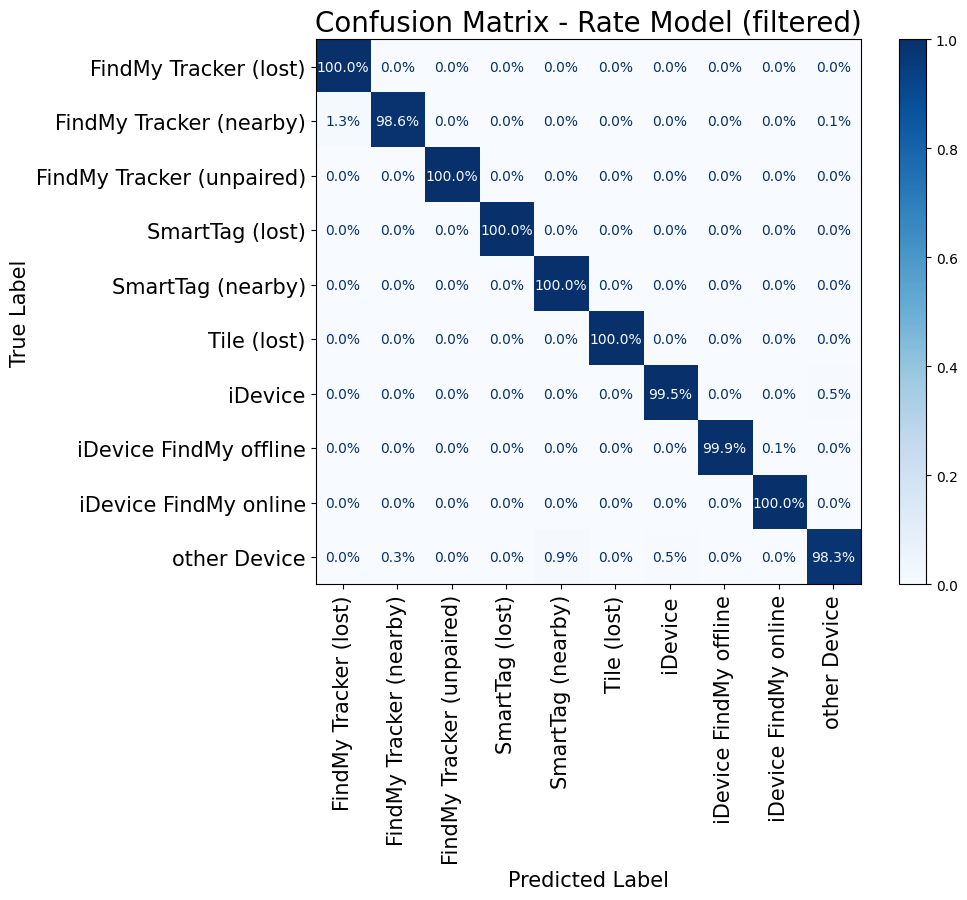

In [19]:
data_filtered = prepareDataset(data_filtered, shuffle=True, balance=True)
modelName = "Rate Model (filtered)"
model, scaler, score = evaluateModel(data_filtered.copy(deep = True), saveName=modelName, model =  DecisionTreeClassifier(random_state = 0))

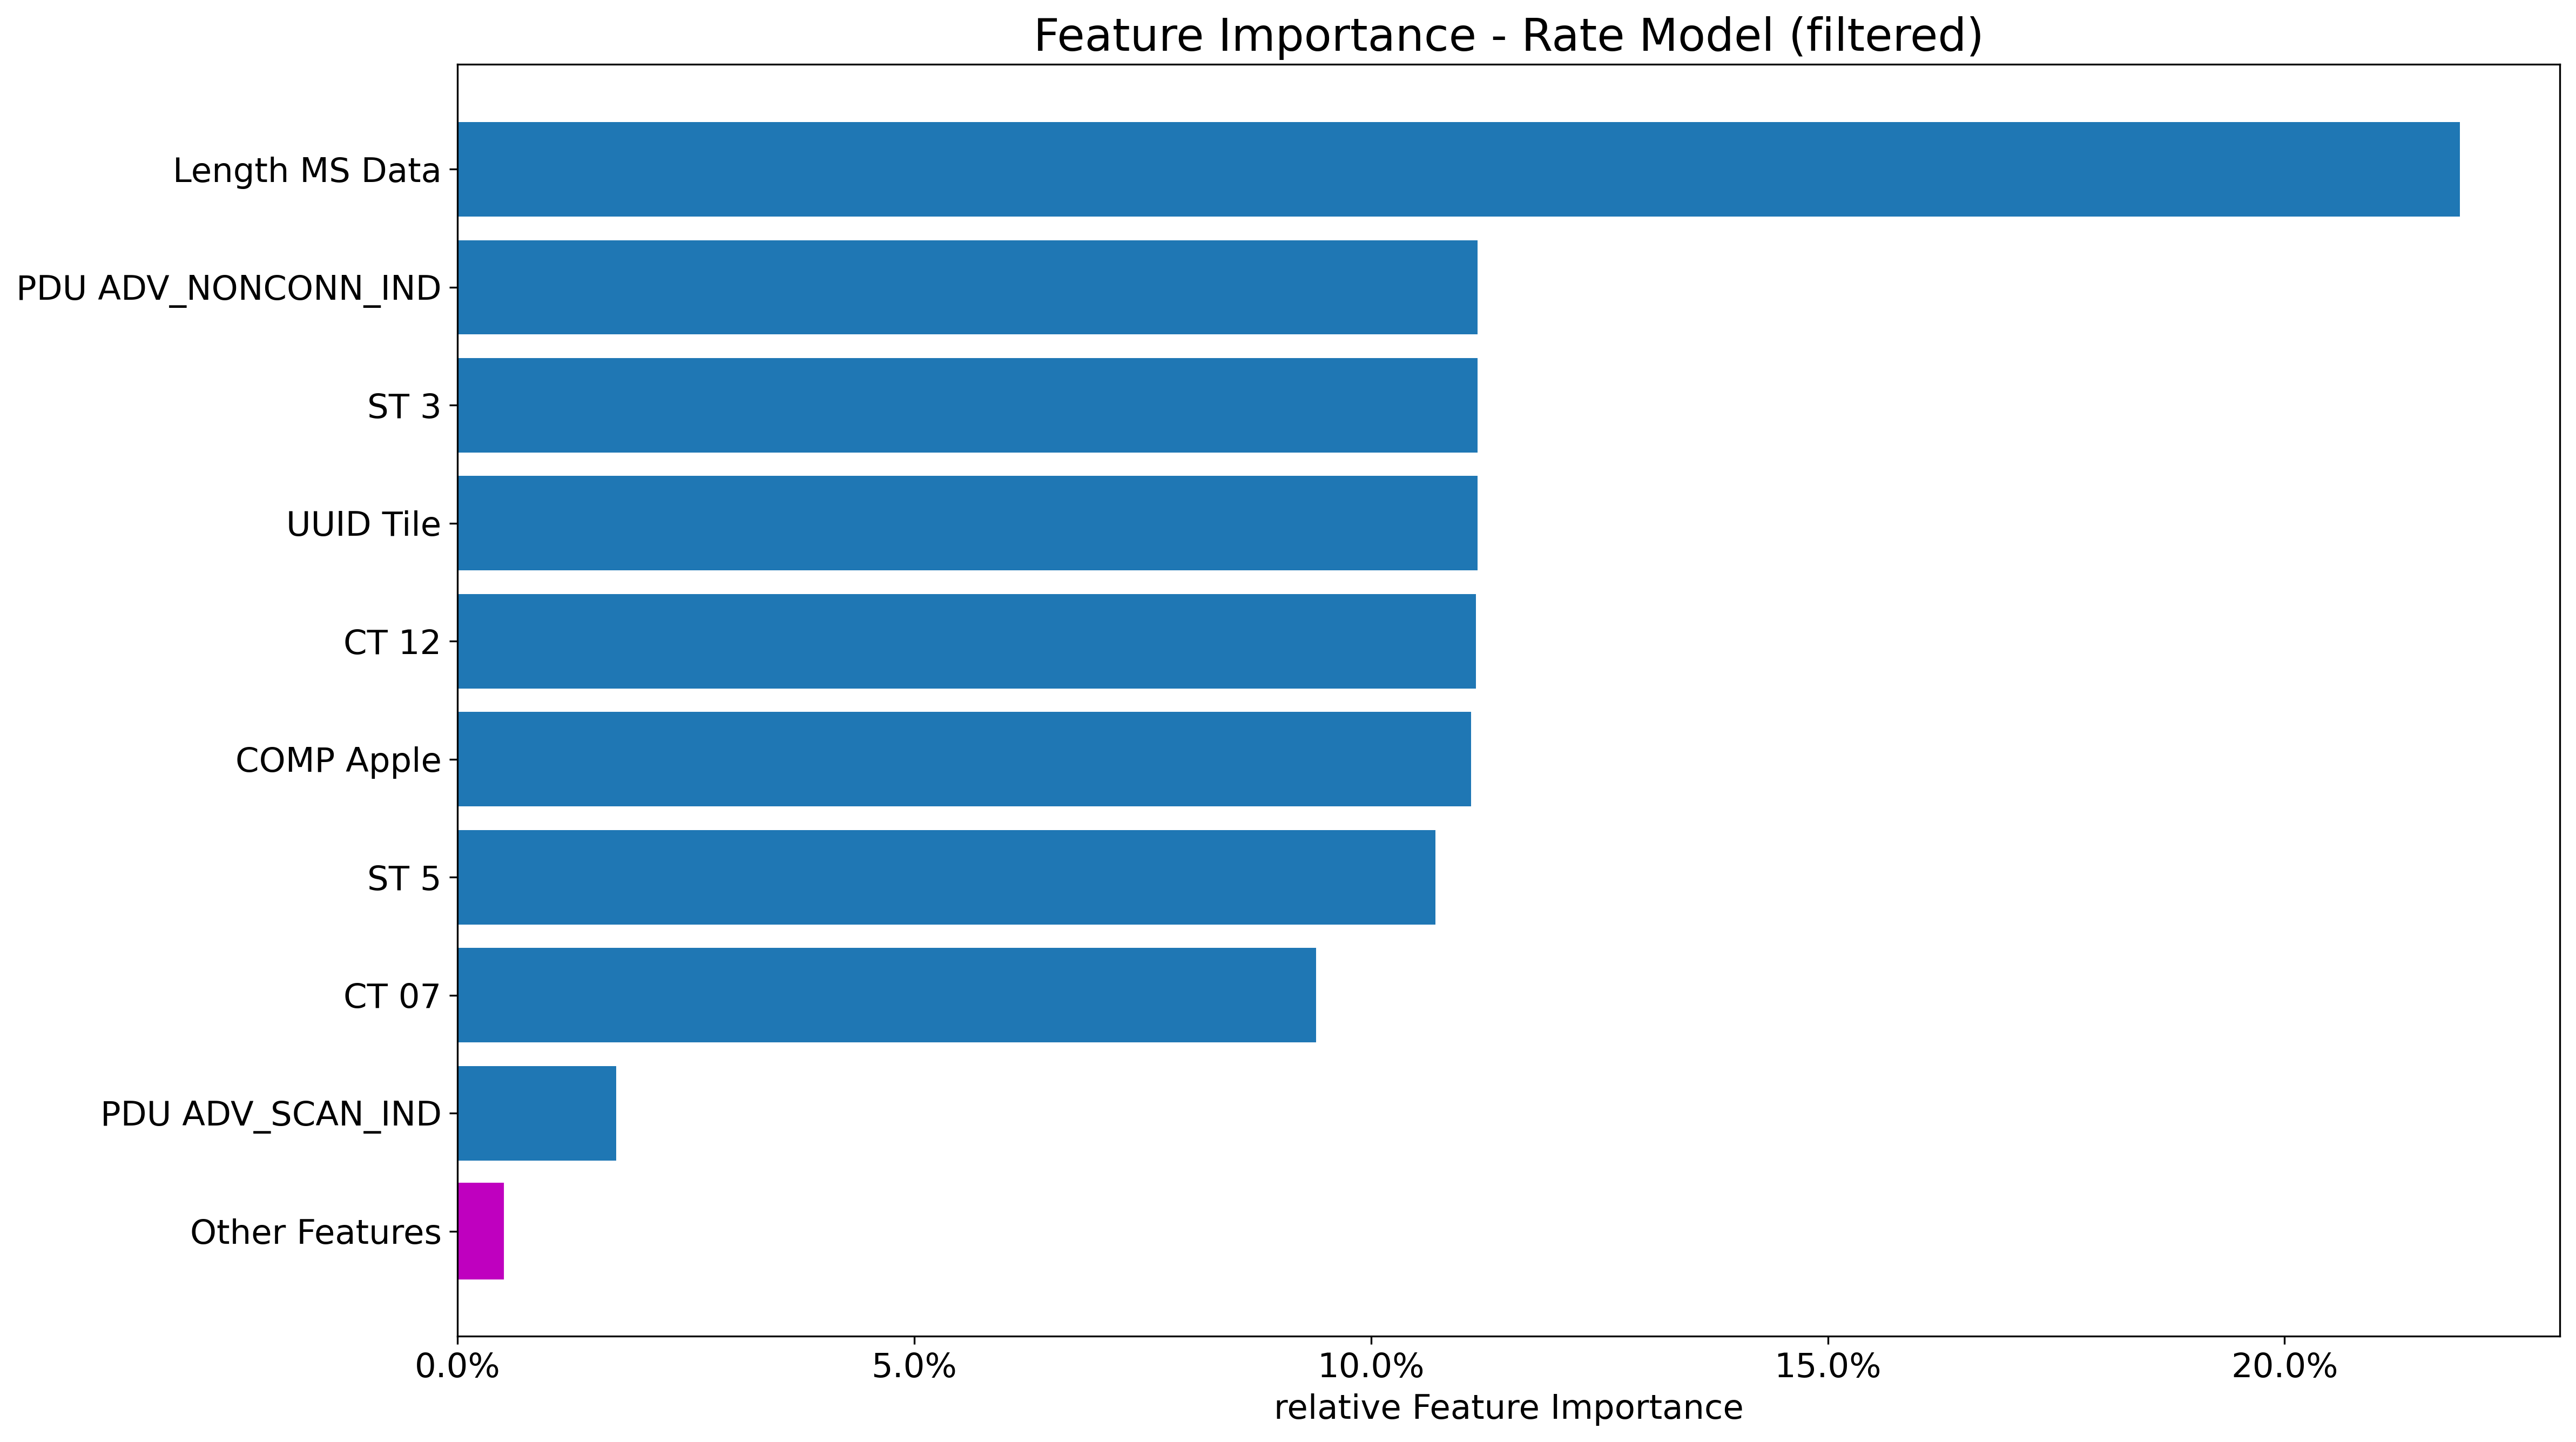

In [20]:
plotFeatureImportance(data.columns[:-1], model.feature_importances_, savePath=plotPath, name=modelName)

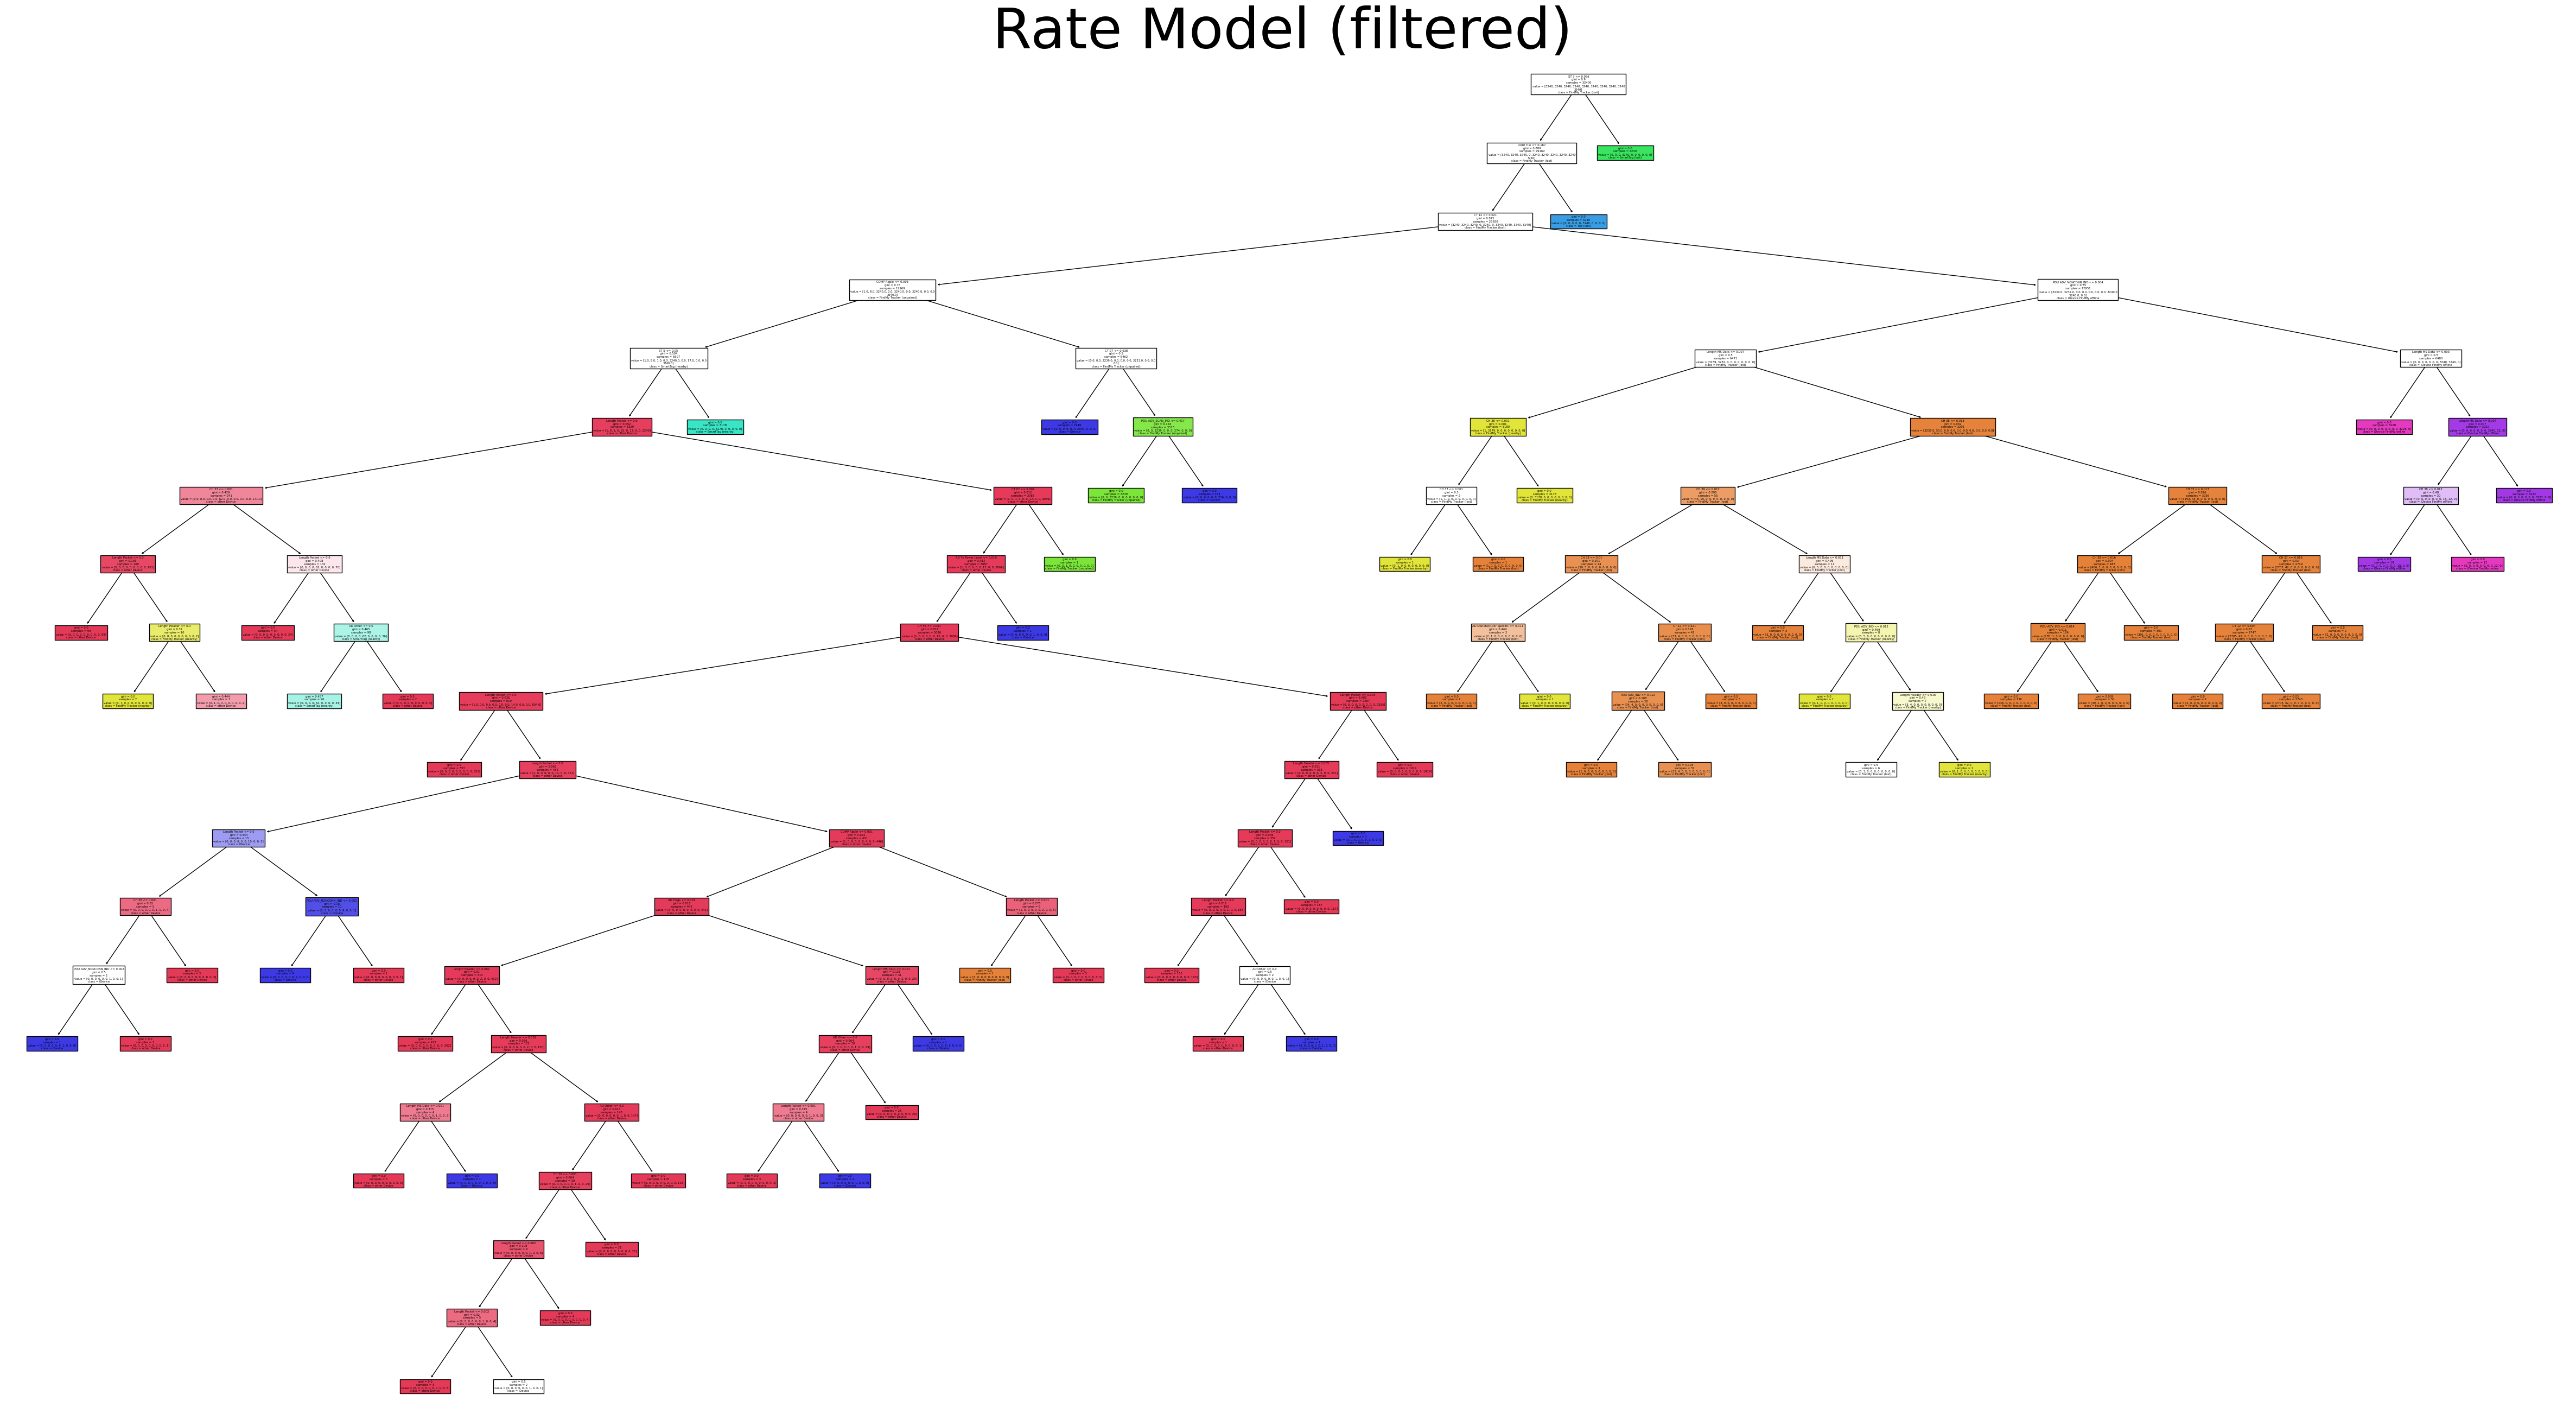

In [21]:
plotTree(model, savePath=plotPath, features_names= data.columns[:-1], name=modelName, sizeFactor=3)